# Level 1 VQ-VAE Run Script

## Import a bunch of libraries

In [1]:
import IPython

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
import yaml
import matplotlib.pyplot as plt
import torchaudio

from models.level_1_vqvae import Lvl1VQVariationalAutoEncoder
from loaders.music_loader import MP3SliceDataset

## Load configuration file and add the weights path

In [2]:
config_path = "config/lvl1_config.yaml"
#weights_path = "model_weights/lvl1_vqvae.ckpt"
weights_path = "model_best.ckpt"
with open(config_path, "r") as f:
    cfg_dict = yaml.safe_load(f)
cfg = {**cfg_dict['model'], **cfg_dict['learning']}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load the model

In [3]:
model = Lvl1VQVariationalAutoEncoder(**cfg)
model = model.load_from_checkpoint(weights_path, **cfg).to(device=device)
model.eval()

Lvl1VQVariationalAutoEncoder(
  (encoder): Lvl1Encoder(
    (init_conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv_list): ModuleList(
      (0): ConvBlock1D(
        (architecture): Sequential(
          (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
          (1): GELU()
          (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): GELU()
        )
      )
      (1): ConvBlock1D(
        (architecture): Sequential(
          (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
          (1): GELU()
          (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): GELU()
        )
      )
      (2): ConvBlock1D(
        (architecture): Sequential(
          (0): Conv1d(128, 256, kernel_si

In [4]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/mp3" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

## Load a dataset sample and display it

Loading file data/music_samples/000-datatensor.pt...
Music file data/music_samples/000-datatensor.pt is loaded.


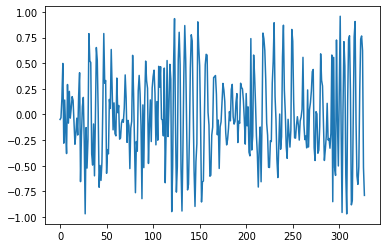

In [5]:
dataset = MP3SliceDataset(preload=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for sample in dataloader:
    music_sample = sample['music slice'].squeeze(0)
    break
plt.plot(music_sample[0, ::100].cpu().detach().numpy())
plt.show()
torchaudio.save('sample.mp3', music_sample.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample.mp3")

## Run the dataset sample through the Lvl1VQVAE

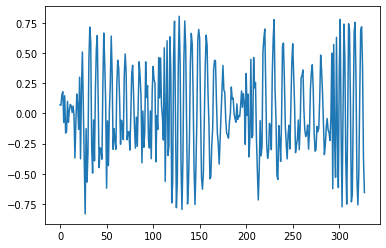

In [6]:
music_sample = music_sample.to(device)
output = model(music_sample.unsqueeze(0), extract_losses=False)
music_sample_rec = output['output'][0]
plt.plot(music_sample_rec[0, ::100].cpu().detach().numpy())
plt.show()
torchaudio.save('sample_out.mp3', music_sample_rec.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")

# Denoiser

## Load model

In [7]:
from models.unet_denoiser import WaveUNet_Denoiser
weights_path = 'model_weights/denoiser.ckpt'
cfg_path = 'config/denoiser_config.yaml'
with open(cfg_path, "r") as f:
    cfg_dict = yaml.safe_load(f)
cfg_den = {**cfg_dict['model'], **cfg_dict['learning']}
denoiser = WaveUNet_Denoiser(**cfg_den)
denoiser = denoiser.load_from_checkpoint(weights_path, **cfg_den, strict=False).to(device=device)
denoiser.eval()

RuntimeError: Error(s) in loading state_dict for WaveUNet_Denoiser:
	size mismatch for encoder.0.weight: copying a param with shape torch.Size([8, 1, 15]) from checkpoint, the shape in current model is torch.Size([16, 1, 15]).
	size mismatch for encoder.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.1.weight: copying a param with shape torch.Size([16, 8, 15]) from checkpoint, the shape in current model is torch.Size([32, 16, 15]).
	size mismatch for encoder.1.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.2.weight: copying a param with shape torch.Size([24, 16, 15]) from checkpoint, the shape in current model is torch.Size([48, 32, 15]).
	size mismatch for encoder.2.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for encoder.3.weight: copying a param with shape torch.Size([32, 24, 15]) from checkpoint, the shape in current model is torch.Size([64, 48, 15]).
	size mismatch for encoder.3.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for encoder.4.weight: copying a param with shape torch.Size([40, 32, 15]) from checkpoint, the shape in current model is torch.Size([80, 64, 15]).
	size mismatch for encoder.4.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for encoder.5.weight: copying a param with shape torch.Size([48, 40, 15]) from checkpoint, the shape in current model is torch.Size([96, 80, 15]).
	size mismatch for encoder.5.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for encoder.6.weight: copying a param with shape torch.Size([56, 48, 15]) from checkpoint, the shape in current model is torch.Size([112, 96, 15]).
	size mismatch for encoder.6.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for encoder.7.weight: copying a param with shape torch.Size([64, 56, 15]) from checkpoint, the shape in current model is torch.Size([128, 112, 15]).
	size mismatch for encoder.7.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.8.weight: copying a param with shape torch.Size([72, 64, 15]) from checkpoint, the shape in current model is torch.Size([144, 128, 15]).
	size mismatch for encoder.8.bias: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for encoder.9.weight: copying a param with shape torch.Size([80, 72, 15]) from checkpoint, the shape in current model is torch.Size([160, 144, 15]).
	size mismatch for encoder.9.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for decoder.0.weight: copying a param with shape torch.Size([80, 160, 5]) from checkpoint, the shape in current model is torch.Size([160, 320, 5]).
	size mismatch for decoder.0.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([160]).
	size mismatch for decoder.1.weight: copying a param with shape torch.Size([72, 152, 5]) from checkpoint, the shape in current model is torch.Size([144, 304, 5]).
	size mismatch for decoder.1.bias: copying a param with shape torch.Size([72]) from checkpoint, the shape in current model is torch.Size([144]).
	size mismatch for decoder.2.weight: copying a param with shape torch.Size([64, 136, 5]) from checkpoint, the shape in current model is torch.Size([128, 272, 5]).
	size mismatch for decoder.2.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for decoder.3.weight: copying a param with shape torch.Size([56, 120, 5]) from checkpoint, the shape in current model is torch.Size([112, 240, 5]).
	size mismatch for decoder.3.bias: copying a param with shape torch.Size([56]) from checkpoint, the shape in current model is torch.Size([112]).
	size mismatch for decoder.4.weight: copying a param with shape torch.Size([48, 104, 5]) from checkpoint, the shape in current model is torch.Size([96, 208, 5]).
	size mismatch for decoder.4.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for decoder.5.weight: copying a param with shape torch.Size([40, 88, 5]) from checkpoint, the shape in current model is torch.Size([80, 176, 5]).
	size mismatch for decoder.5.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([80]).
	size mismatch for decoder.6.weight: copying a param with shape torch.Size([32, 72, 5]) from checkpoint, the shape in current model is torch.Size([64, 144, 5]).
	size mismatch for decoder.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.7.weight: copying a param with shape torch.Size([24, 56, 5]) from checkpoint, the shape in current model is torch.Size([48, 112, 5]).
	size mismatch for decoder.7.bias: copying a param with shape torch.Size([24]) from checkpoint, the shape in current model is torch.Size([48]).
	size mismatch for decoder.8.weight: copying a param with shape torch.Size([16, 40, 5]) from checkpoint, the shape in current model is torch.Size([32, 80, 5]).
	size mismatch for decoder.8.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for decoder.9.weight: copying a param with shape torch.Size([8, 24, 5]) from checkpoint, the shape in current model is torch.Size([16, 48, 5]).
	size mismatch for decoder.9.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for middle_layer.0.weight: copying a param with shape torch.Size([80, 80, 15]) from checkpoint, the shape in current model is torch.Size([160, 160, 15]).
	size mismatch for middle_layer.0.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([160]).

: 

## Run a sample through the denoiser

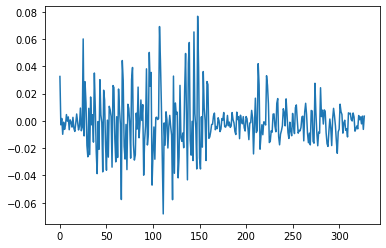

: 

In [ ]:
output = denoiser(music_sample_rec.unsqueeze(0))
music_sample_den = output['output'][0]
plt.plot(music_sample_den[0, ::100].cpu().detach().numpy())
plt.show()
torchaudio.save('sample_out.mp3', music_sample_den.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")